In [ ]:
# Importing Required Libraries
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report , confusion_matrix, accuracy_score
from keras.models import Sequential 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Bhushan0130/Datasets/main/amazon_alexa.tsv', sep = '\t')

In [ ]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
def sentiments(df):
  if df['rating'] > 3.0:
    return 'Positive'
  
  elif df['rating']<=3.0:
    return 'Negative'

data['sentiments'] = data.apply(sentiments, axis=1)

In [ ]:
data.head()

,rating,date,variation,verified_reviews,feedback,sentiments
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive


In [ ]:
!pip install wordcloud

In [ ]:
df = data[['verified_reviews', 'sentiments']]

In [ ]:
df.isnull().sum()

verified_reviews    0
sentiments          0
dtype: int64

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Replace email address with email:[
df['verified_reviews'] = df['verified_reviews'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'email_address')
df['sentiments'] = df['sentiments'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'email_address')

In [ ]:
# Replace URL with 'webaddress'
df['verified_reviews'] = df['verified_reviews'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')
df['sentiments'] = df['sentiments'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

In [ ]:
# Replace money symbols with 'moneysymb' (£ can be typed with ALT key + 156)
df['verified_reviews'] = df['verified_reviews'].str.replace(r'£|\$', 'dollers')
df['sentiments'] = df['sentiments'].str.replace(r'£|\$', 'dollers')

In [ ]:
# Replace 10 digit phone numbers (formats include paranthesis spaces, no spaces, dashed) with 'phonenumber'
df['verified_reviews'] = df['verified_reviews'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone_number')
df['sentiments'] = df['sentiments'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone_number')

In [ ]:
# Replace numbers with 'number'
df['verified_reviews'] = df['verified_reviews'].str.replace(r'\d+(\.\d+)?', 'number')
df['sentiments'] = df['sentiments'].str.replace(r'\d+(\.\d+)?', 'number')

In [ ]:
# Remove punctuation
df['verified_reviews'] = df['verified_reviews'].str.replace(r'[^\w\d\s]', ' ')
df['sentiments'] = df['sentiments'].str.replace(r'[^\w\d\s]', ' ')

In [ ]:
# Replace whitespace between terms with a single space:
df['verified_reviews'] = df['verified_reviews'].str.replace(r'\s+', ' ')
df['sentiments'] = df['sentiments'].str.replace(r'\s+', ' ')

In [ ]:
# Remove leading and trailing whitespace
df['verified_reviews'] = df['verified_reviews'].str.replace(r'^\s+|\s+?$', ' ')
df['sentiments'] = df['sentiments'].str.replace(r'^\s+|\s+?$', ' ')

In [ ]:
df['verified_reviews'] = df.verified_reviews.apply(lambda x: ' '.join(x.lower() for x in x.split()))

In [ ]:
df['sentiments'] = df.sentiments.apply(lambda x: ' '.join(x.lower() for x in x.split()))

In [ ]:
df.head()

,verified_reviews,sentiments
0,love my echo,positive
1,loved it,positive
2,sometimes while playing a game you can answer ...,positive
3,i have had a lot of fun with this thing my num...,positive
4,music,positive


In [ ]:
import nltk
nltk.download('stopwords')

import string
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = stopwords.words('english') + ['u', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
df['verified_reviews'] = df['verified_reviews'].apply(lambda x : ' '.join(word for word in x.split() if word not in stop_words ))
df['sentiments'] = df['sentiments'].apply(lambda x : ' '.join(word for word in x.split() if word not in stop_words ))

In [ ]:
common_words = ''

for i in df.verified_reviews:
  i = str(i)
  tokens = i.split()
  common_words += " ".join(tokens)+" "

In [ ]:
from wordcloud import WordCloud 

In [ ]:
common_words

'love echo loved sometimes playing game answer question correctly alexa says got wrong answers like able turn lights away home lot fun thing number yr old learns dinosaurs control lights play games like categories nice sound playing music well music received echo gift needed another bluetooth something play music easily accessible found smart speaker wait see else without cellphone cannot use many features ipad see use great alarm r almost deaf hear alarm bedroom living room reason enough keep fun ask random questions hear response seem smartbon politics yet think numberth one purchased working getting one every room house really like features offer specifily playing music echos controlling lights throughout house looks great love listened songs heard since childhood get news weather information great sent number year old dad talks constantly love learning knew things eveyday still figuring everything works far easy use understand make laugh times purchased mother knee problems give so

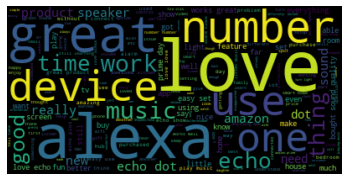

In [ ]:
word_cloud = WordCloud().generate(common_words)
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Encoded the target column
lb = LabelEncoder()
df['sentiments'] = lb.fit_transform(df['sentiments'])

In [ ]:
# Dealing with feature columns
tokenize = Tokenizer(num_words = 500, split = ' ')
tokenize.fit_on_texts(df['verified_reviews'].values)

In [ ]:
X = tokenize.texts_to_sequences(data['verified_reviews'].values)
X

[[1, 2],
 [172],
 [182, 100, 231, 470, 4, 289, 43, 471, 381, 7, 58, 69, 63, 254, 21],
 [90, 37, 46, 137, 95, 63, 22, 255, 7, 67, 12, 100, 6, 35],
 [6],
 [368, 2, 138, 277, 80, 121, 142, 22, 6, 246, 290, 28, 19, 428, 73, 247],
 [81,
  303,
  8,
  75,
  105,
  73,
  8,
  3,
  52,
  256,
  139,
  52,
  86,
  200,
  45,
  208,
  166,
  232,
  37,
  53,
  103,
  139,
  403,
  499,
  146],
 [82, 10, 91, 101, 76, 10, 110, 45, 50, 26, 7, 105, 100, 6, 291, 63, 320, 50],
 [217, 3],
 [1, 167, 429, 168, 18, 127, 59, 173, 3],
 [233, 137],
 [1, 54, 40, 24, 49, 9, 41, 11, 8, 174, 108, 128],
 [91,
  472,
  179,
  267,
  142,
  188,
  201,
  76,
  144,
  268,
  7,
  56,
  189,
  40,
  4,
  22,
  234,
  25],
 [1, 1, 1],
 [122],
 [1, 209],
 [26, 114, 83, 3, 19, 11, 13],
 [64, 4, 304, 343, 90, 37, 29, 7, 29, 369, 188, 175, 156, 201],
 [1, 123, 197, 2, 24, 210, 56, 12],
 [430,
  147,
  2,
  117,
  269,
  404,
  47,
  189,
  235,
  269,
  35,
  7,
  8,
  321,
  84,
  180,
  38,
  24,
  381,
  4,
  2,
  292,

In [ ]:
X = pad_sequences(X)

In [ ]:
X

array([[  0,   0,   0, ...,   0,   1,   2],
       [  0,   0,   0, ...,   0,   0, 172],
       [  0,   0,   0, ...,  63, 254,  21],
       ...,
       [  0,   0,   0, ...,  77,  44,  28],
       [  0,   0,   0, ..., 108, 111, 106],
       [  0,   0,   0, ...,   0,   0,  15]], dtype=int32)

In [ ]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1] ))
model.add(SpatialDropout1D(0.4))

In [ ]:
# Embedding: words have been converted into number but they are random numbers, so we need to convert these into vector 

In [ ]:
# our output should have 176 features 
model.add(LSTM(176, dropout = 0.2, recurrent_dropout = 0.2 ))
model.add(Dense(2, activation = 'softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 161, 120)          60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 161, 120)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
y = pd.get_dummies(df['sentiments'])
print(y)

      0  1
0     0  1
1     0  1
2     0  1
3     0  1
4     0  1
...  .. ..
3145  0  1
3146  0  1
3147  0  1
3148  0  1
3149  0  1

[3150 rows x 2 columns]


In [ ]:
X

array([[  0,   0,   0, ...,   0,   1,   2],
       [  0,   0,   0, ...,   0,   0, 172],
       [  0,   0,   0, ...,  63, 254,  21],
       ...,
       [  0,   0,   0, ...,  77,  44,  28],
       [  0,   0,   0, ..., 108, 111, 106],
       [  0,   0,   0, ...,   0,   0,  15]], dtype=int32)

In [ ]:
# Splitting the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
batch_size = 32
model.fit(x_train, y_train, epochs = 5, batch_size = batch_size, verbose = 1)

Epoch 1/5
69/69 [==============================] - 67s 870ms/step - loss: 0.3758 - accuracy: 0.8730
Epoch 2/5
69/69 [==============================] - 47s 688ms/step - loss: 0.2781 - accuracy: 0.8893
Epoch 3/5
69/69 [==============================] - 74s 1s/step - loss: 0.2283 - accuracy: 0.9066
Epoch 4/5
69/69 [==============================] - 51s 724ms/step - loss: 0.1771 - accuracy: 0.9288
Epoch 5/5
69/69 [==============================] - 46s 660ms/step - loss: 0.1561 - accuracy: 0.9392


In [ ]:
model.evaluate(x_test, y_test)

30/30 [==============================] - 3s 90ms/step - loss: 0.2598 - accuracy: 0.8952


[0.25979042053222656, 0.8952381014823914]